In [54]:
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

import lmfit
from kid_readout.measurement.io import npy
from kid_readout.measurement import basic, plot_basic
from kid_readout.analysis.timeseries import filters, periodic
from kid_readout.analysis.resonator import lmfit_resonator

In [40]:
save_directory = '/home/flanigan/temp/'
save_hwp_response_band_3317 = False
save_hwp_response_fit_band_3317 = False

In [66]:
thesis_directory = '/home/flanigan/thesis/'
save_mkidarray02_chosen_one_fit_hwp = True

In [3]:
npd = npy.NumpyDirectory('/data/readout/2017-12-02_180110_hwp.npd/')

In [4]:
print(npd.metadata.script_code)

"""
Measure one group of resonances simultaneously.
"""
from __future__ import division
import time

import numpy as np

from kid_readout.roach import analog, hardware_tools, tools
from kid_readout.measurement import acquire, basic, core
from kid_readout.equipment import hardware, starcryo_temps
from equipment.srs import lockin
from equipment.custom import mmwave_source
from xystage import stepper
from kid_readout.settings import LOCKIN_SERIAL_PORT, CRYOGENIC_HWP_MOTOR_SERIAL_PORT
import resonances

acquire.show_settings()
acquire.show_git_status()
logger = acquire.get_script_logger(__file__)

# Parameters
suffix = 'hwp'
df_baseband_target = 30e3
f_sweep_span_maximum = 3e6
f_lo_spacing = 2.5e3
f_baseband_minimum = 10e6  # Keep the tones away from the LO by at least this frequency.
f_baseband_maximum = 200e6  # Place dummy tones above this frequency
sweep_length_seconds = 0.01
stream_length_seconds = 1
num_hwp_angles = 100
num_hwp_increments_per_angle = 1
wait_between_increments = 0
wai

In [5]:
npd.node_names()

['SweepStreamList0', 'ADCSnap1']

In [6]:
ssl = npd.SweepStreamList0
snap = npd.ADCSnap1

# ADCSnap

In [7]:
snap.x.ptp(), snap.y.ptp()

(58.0, 57.0)

# Temperatures

In [8]:
package_color = 'C0'
eccosorb_color = 'C1'
stepper_color = 'C2'

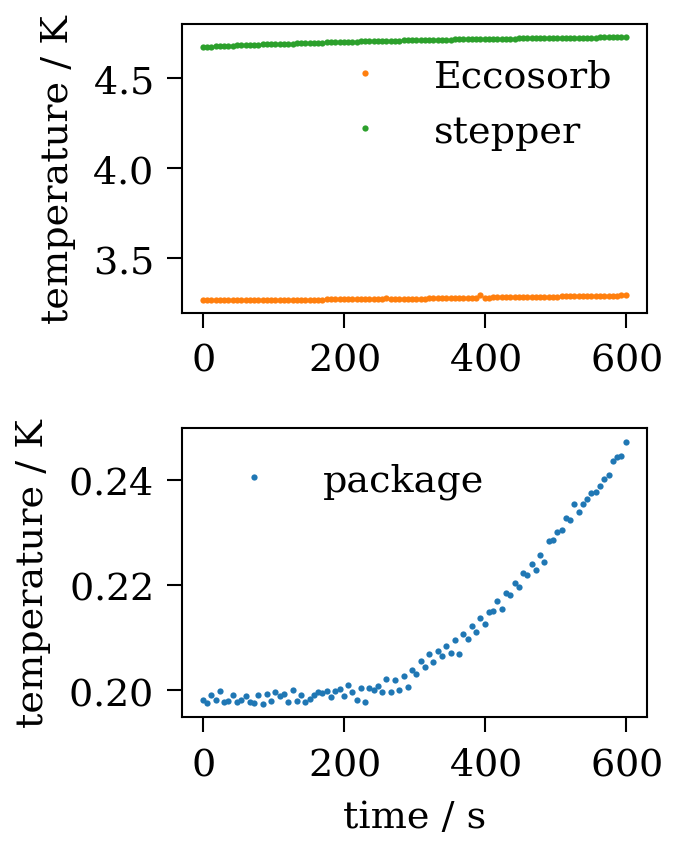

In [9]:
fig, (diode_ax, package_ax) = plt.subplots(2, 1, figsize=(2, 3), gridspec_kw={'hspace': 0.4})
diode_ax.set_ylabel('temperature / K')
package_ax.set_ylabel('temperature / K')
package_ax.set_xlabel('time / s')

time = [stream.epoch - ssl.stream_list[0].epoch for stream in ssl.stream_list]
package = [stream.state.temperature.package_ruox4550_temperature for stream in ssl.stream_list]
eccosorb = [stream.state.temperature.eccosorb_diode_temperature for stream in ssl.stream_list]
stepper = [stream.state.temperature.stepper_diode_temperature for stream in ssl.stream_list]

package_ax.plot(time, package, '.', color=package_color, label='package')
diode_ax.plot(time, eccosorb, '.', color=eccosorb_color, label='Eccosorb')
diode_ax.plot(time, stepper, '.', color=stepper_color, label='stepper')

package_ax.legend()
diode_ax.legend()

# Lock-in voltage

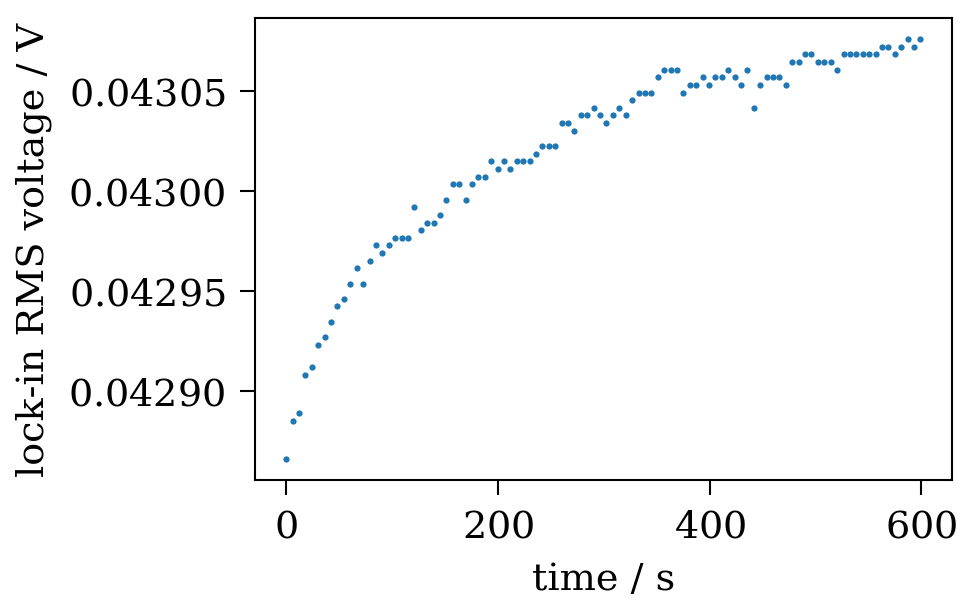

In [10]:
time = [stream.epoch - ssl.stream_list[0].epoch for stream in ssl.stream_list]
voltage = [stream.state.lockin.rms_voltage for stream in ssl.stream_list]

fig, ax = plt.subplots()
ax.set_xlabel('time / s')
ax.set_ylabel('lock-in RMS voltage / V')
ax.plot(time, voltage, '.')

# Sweep

In [11]:
ssl.sweep.num_channels

8

In [12]:
ssl.state.num_dummy_frequencies

0

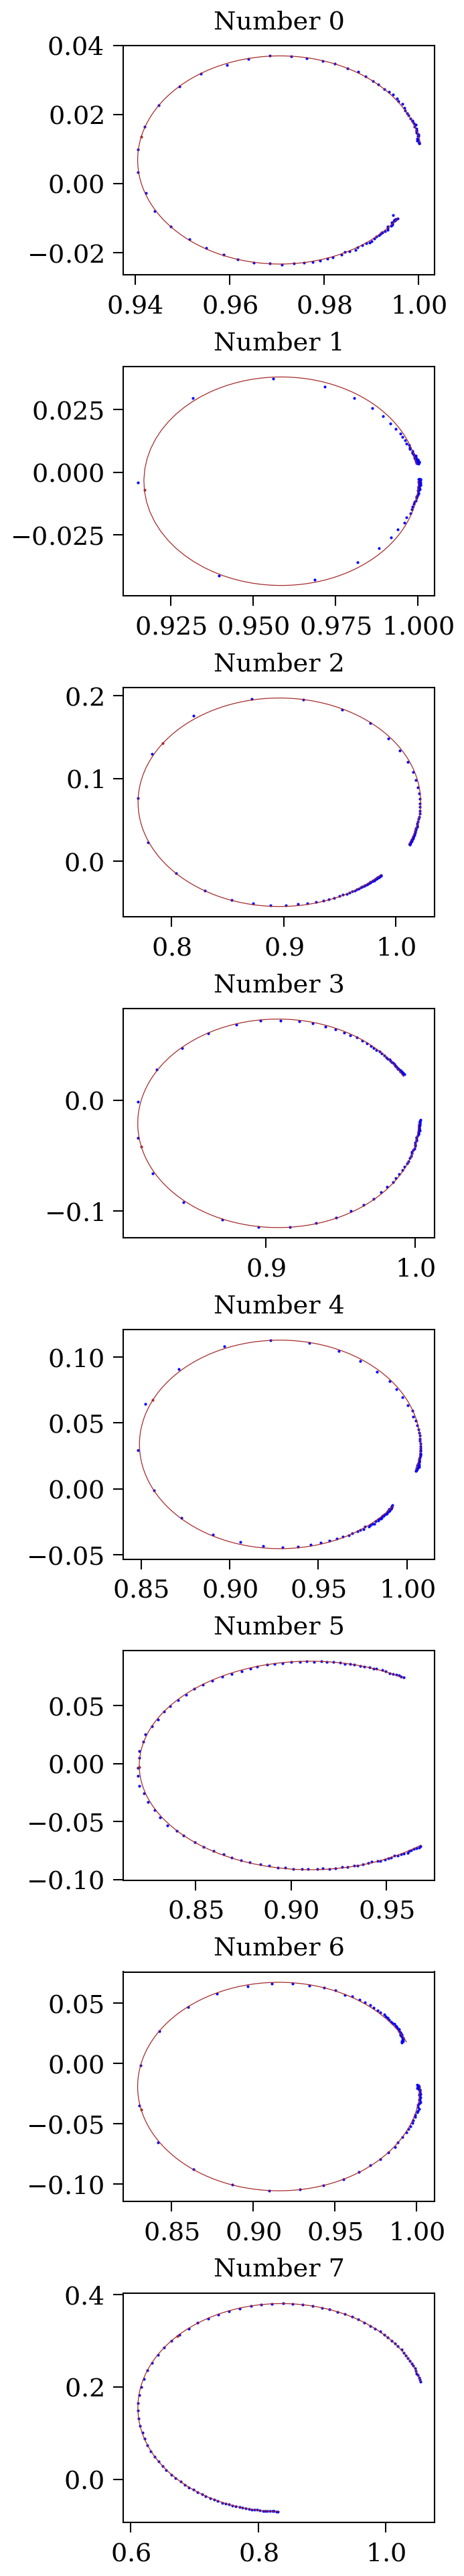

In [13]:
num_channels = ssl.sweep.num_channels - ssl.state.num_dummy_frequencies
fig, axes = plt.subplots(num_channels, figsize=(2, 2 * num_channels), gridspec_kw={'hspace': 0.4})
for number, ax in enumerate(axes):
    plot_basic.resonator_complex_plane(resonator=ssl.sweep[number].resonator, axis=ax, normalize=True)
    ax.set_title("Number {:d}".format(number))

# Streams

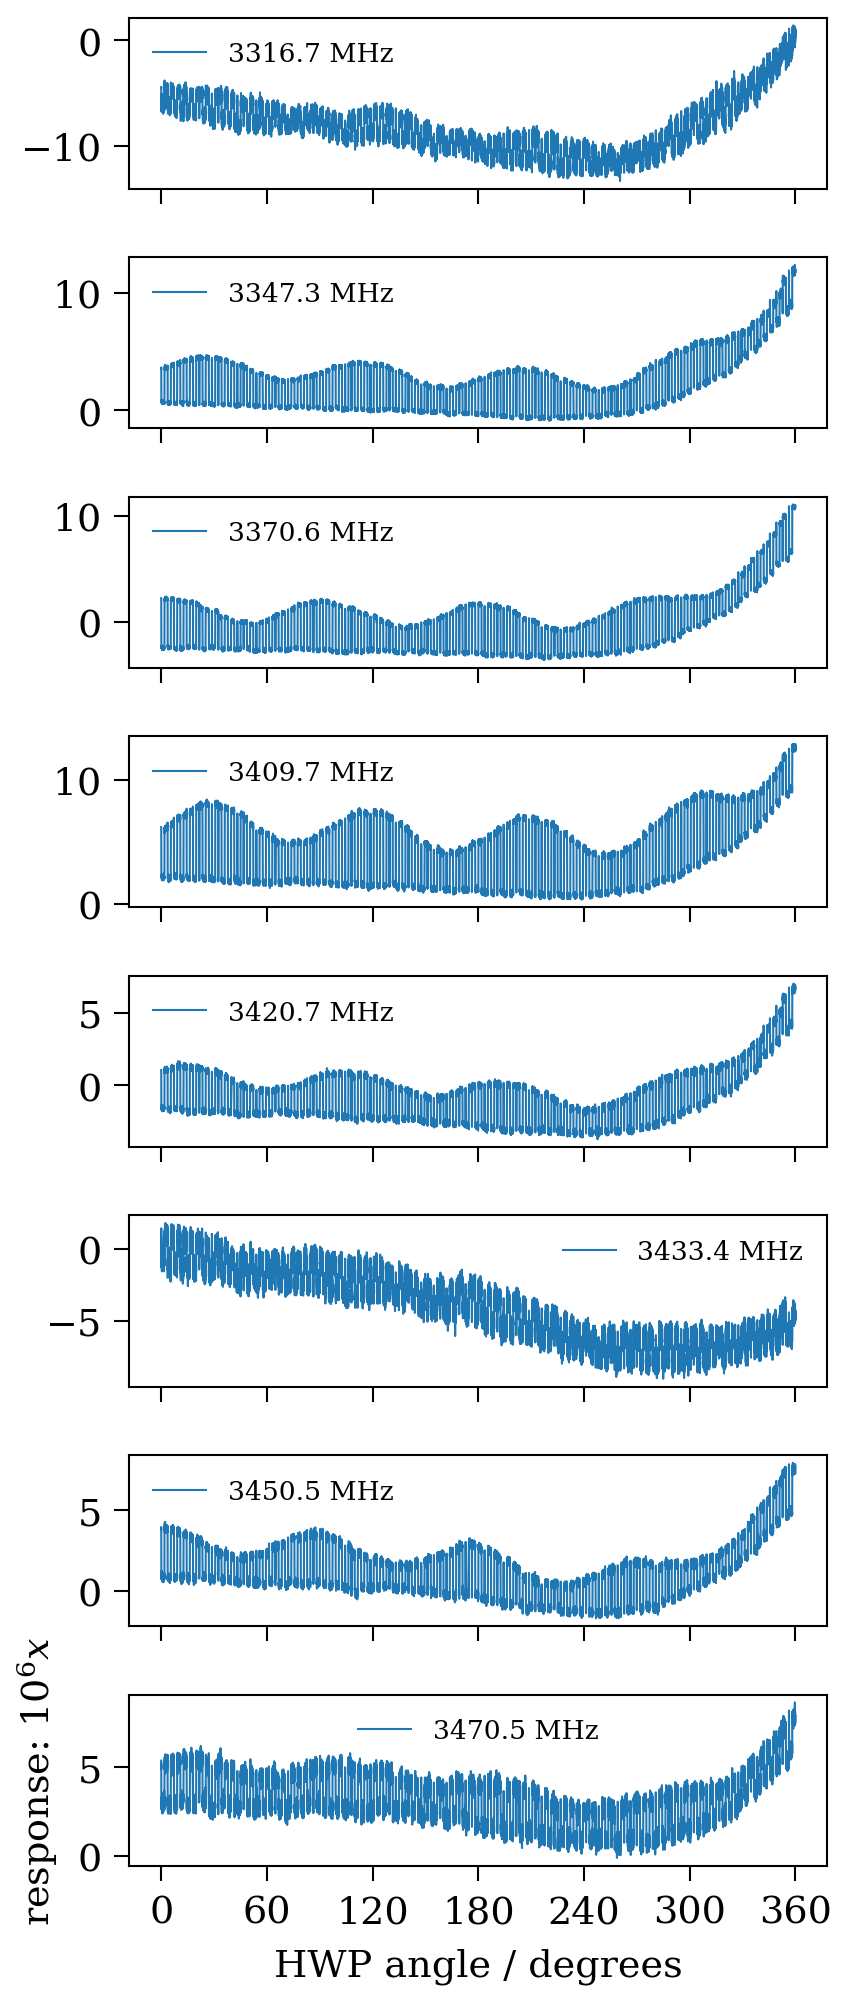

In [43]:
fig, axes = plt.subplots(num_channels, figsize=(3, 1 * num_channels), gridspec_kw={'hspace': 0.4})
for number, ax in enumerate(axes):
    sssl = ssl[number]
    folded = []
    for index, stream in enumerate(sssl.stream_list):
        x, q = sssl.x_and_q(index)
        x_fold = stream.fold(x)
        folded.append(x_fold)
    all_folded = np.concatenate(folded)
    angles = np.linspace(0, 360, all_folded.size)
    ax.plot(angles, 1e6 * all_folded,
            label="{:.1f} MHz".format(1e-6 * sssl.single_sweep.resonator.f_0))
    ax.set_xticks(60 * np.arange(7))
    ax.set_xticklabels([])
    ax.legend(fontsize='xx-small')
axes[-1].set_ylabel('response: $10^{6} x$')
axes[-1].set_xlabel('HWP angle / degrees')
axes[-1].set_xticklabels([str(t) for t in 60 * np.arange(7)]);

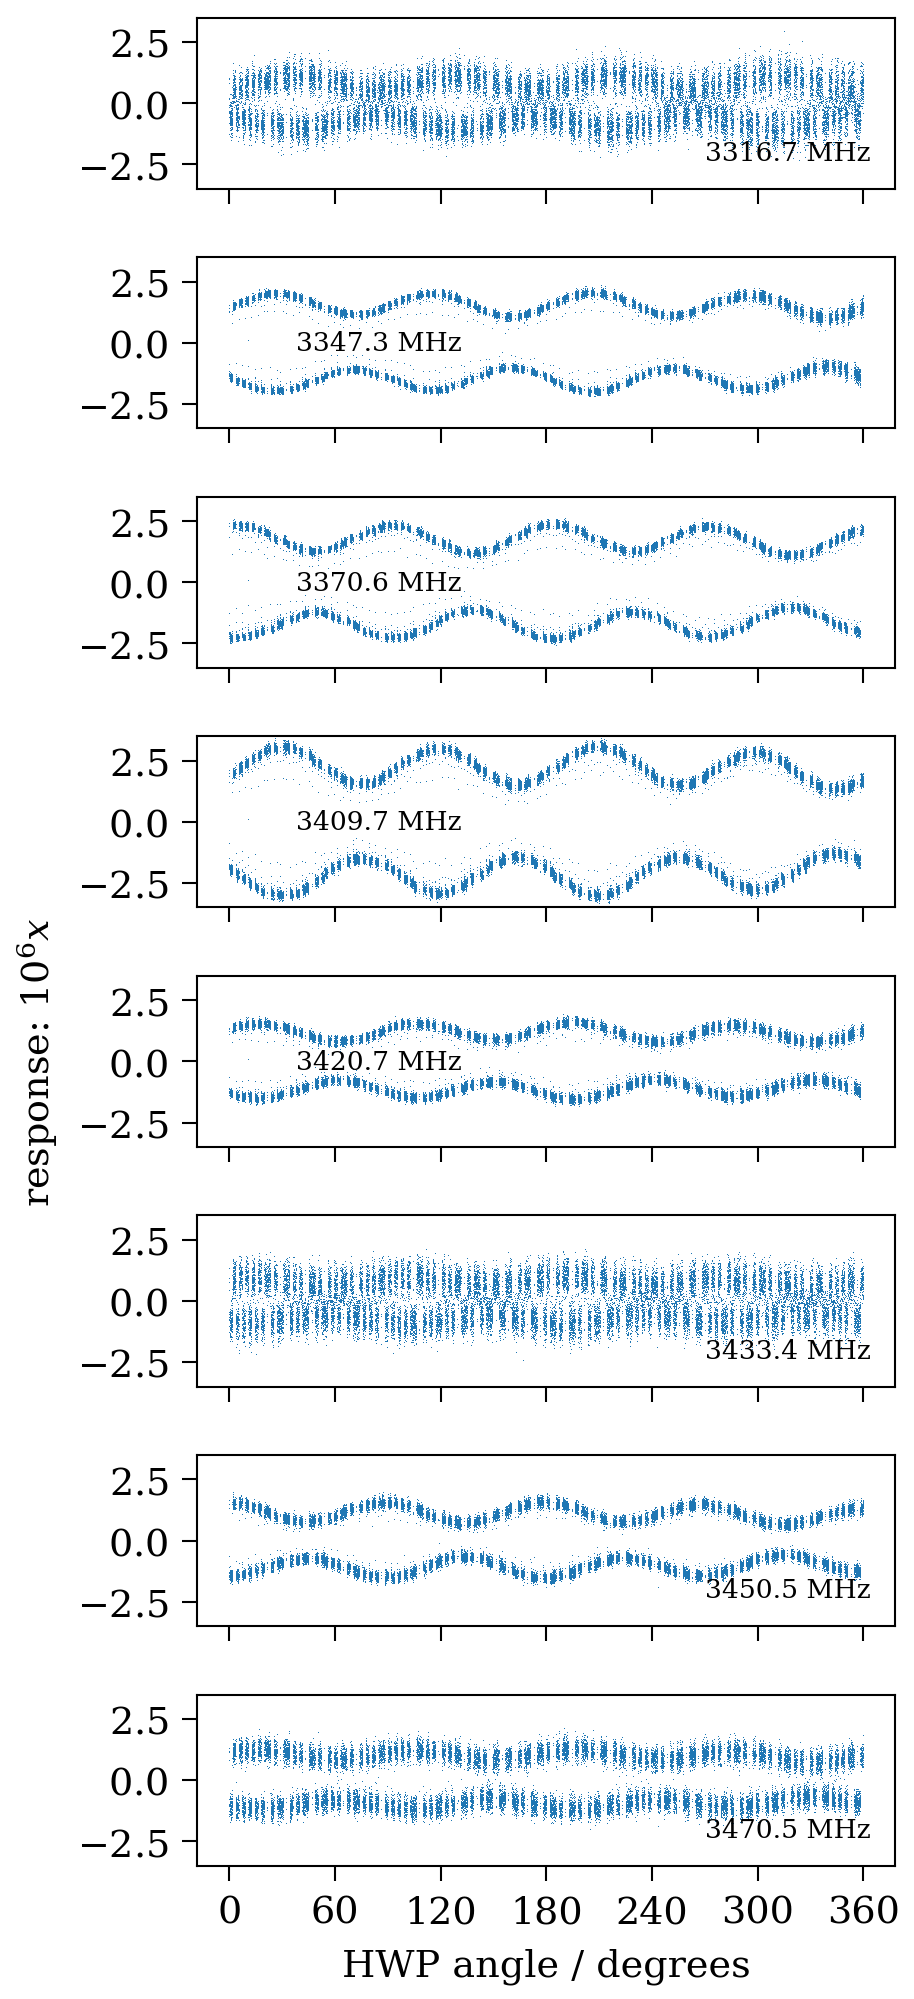

In [45]:
fig, axes = plt.subplots(num_channels, figsize=(3, 1 * num_channels), gridspec_kw={'hspace': 0.4})
for number, ax in enumerate(axes):
    sssl = ssl[number]
    folded = []
    for index, stream in enumerate(sssl.stream_list):
        x, q = sssl.x_and_q(index)
        x_fold = stream.fold(x)
        folded.append(x_fold - x_fold.mean())
    all_folded = np.concatenate(folded)
    angles = np.linspace(0, 360, all_folded.size)
    ax.plot(angles, 1e6 * all_folded, ',',
            label="{:.1f} MHz".format(1e-6 * sssl.single_sweep.resonator.f_0))
    ax.set_xticks(60 * np.arange(7))
    ax.set_xticklabels([])
    ax.set_ylim(-3.5, 3.5)
    ax.legend(fontsize='xx-small')
axes[axes.size // 2].set_ylabel('response: $10^6 x$')
axes[-1].set_xlabel('HWP angle / degrees')
axes[-1].set_xticklabels([str(t) for t in 60 * np.arange(7)]);

if save_all_hwp_response_band_3317:
    fig.savefig(save_directory + 'all_hwp_response_band_3317.pdf')
    fig.savefig(save_directory + 'all_hwp_response_band_3317.png')

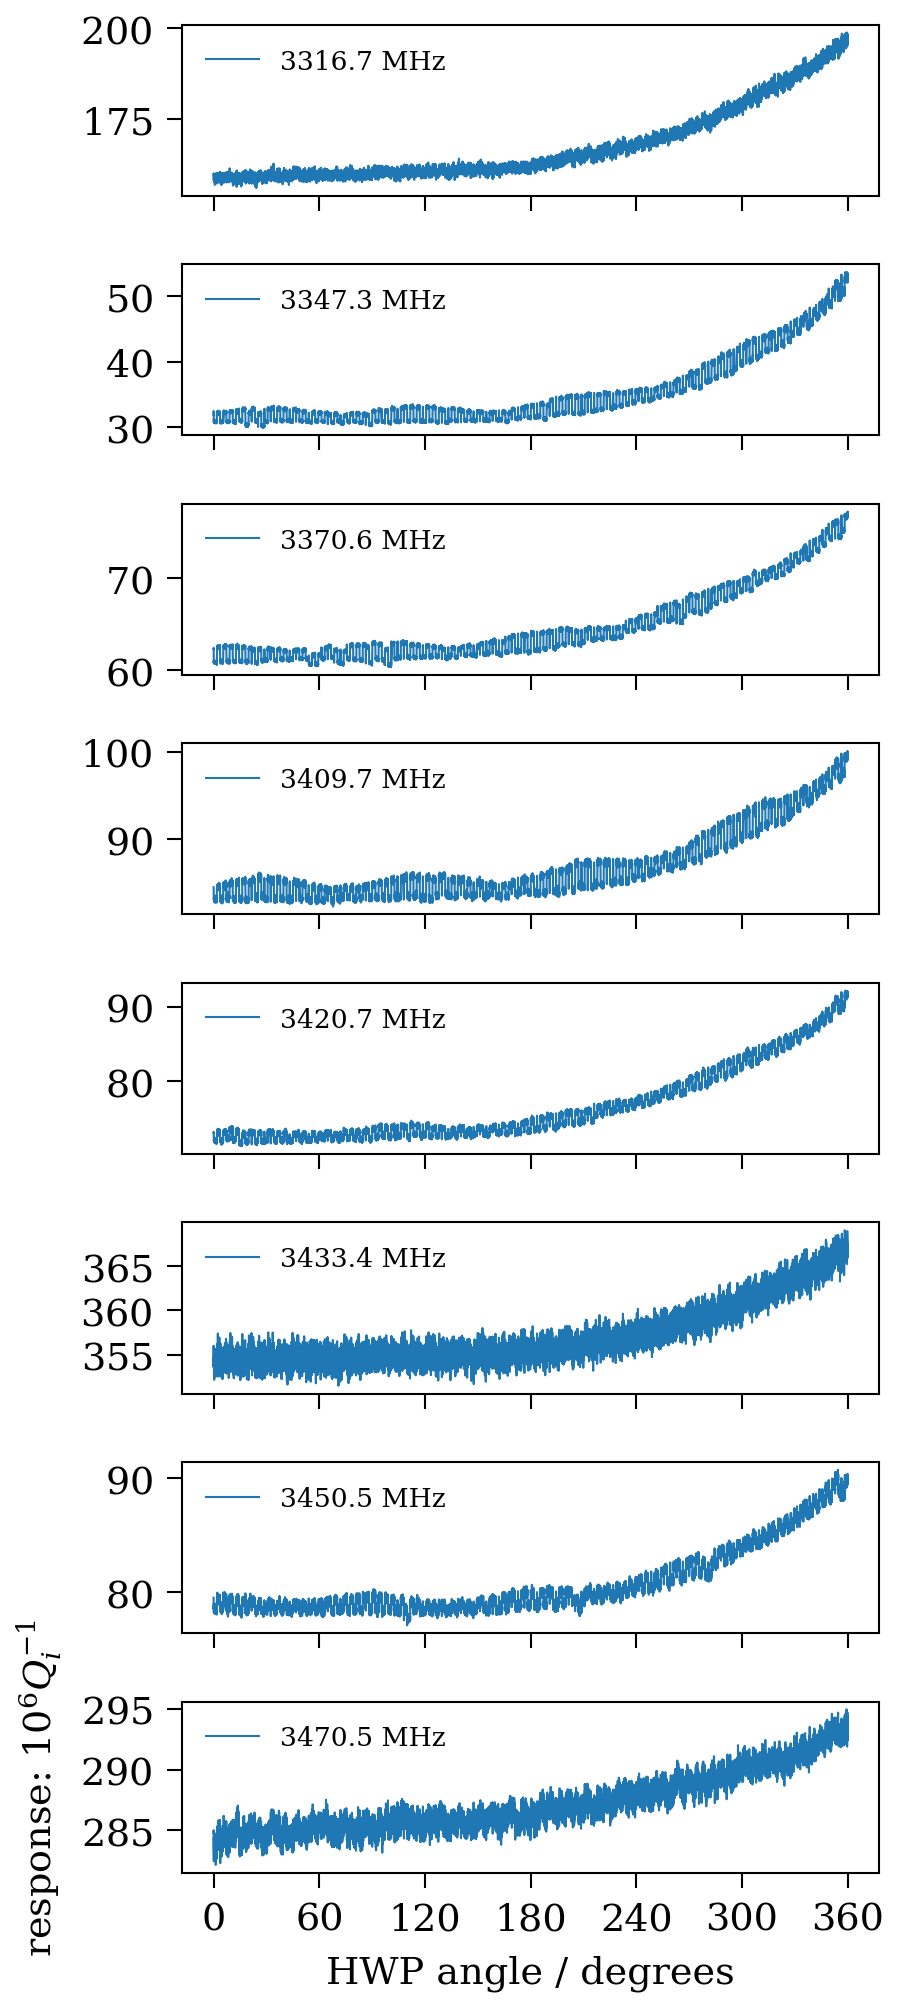

In [46]:
fig, axes = plt.subplots(num_channels, figsize=(3, 1 * num_channels), gridspec_kw={'hspace': 0.4})
for number, ax in enumerate(axes):
    sssl = ssl[number]
    folded = []
    for index, stream in enumerate(sssl.stream_list):
        x, q = sssl.x_and_q(index)
        q_fold = stream.fold(q)
        folded.append(q_fold)
    all_folded = np.concatenate(folded)
    angles = np.linspace(0, 360, all_folded.size)
    ax.plot(angles, 1e6 * all_folded,
            label="{:.1f} MHz".format(1e-6 * sssl.single_sweep.resonator.f_0))
    ax.set_xticks(60 * np.arange(7))
    ax.set_xticklabels([])
    ax.legend(fontsize='xx-small')
axes[-1].set_ylabel('response: $10^{6} Q_i^{-1}$')
axes[-1].set_xlabel('HWP angle / degrees')
axes[-1].set_xticklabels([str(t) for t in 60 * np.arange(7)]);

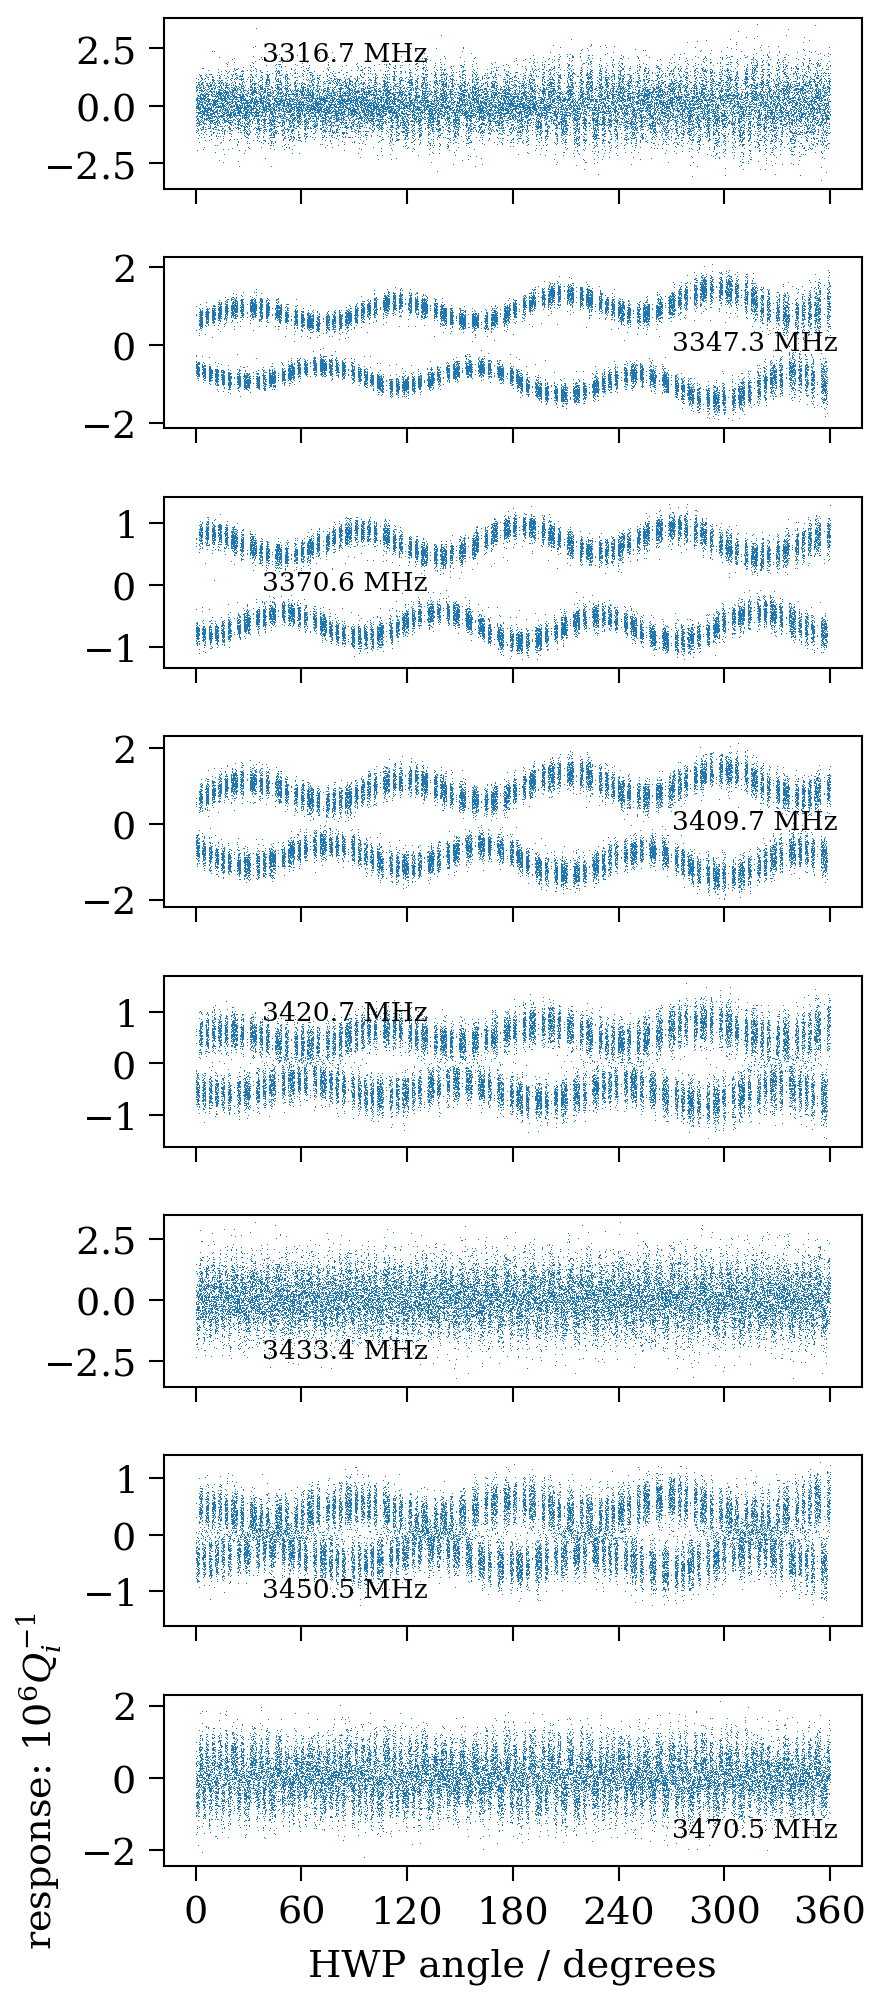

In [47]:
fig, axes = plt.subplots(num_channels, figsize=(3, 1 * num_channels), gridspec_kw={'hspace': 0.4})
for number, ax in enumerate(axes):
    sssl = ssl[number]
    folded = []
    for index, stream in enumerate(sssl.stream_list):
        x, q = sssl.x_and_q(index)
        q_fold = stream.fold(q)
        folded.append(q_fold - q_fold.mean())
    all_folded = np.concatenate(folded)
    angles = np.linspace(0, 360, all_folded.size)
    ax.plot(angles, 1e6 * all_folded, ',',
            label="{:.1f} MHz".format(1e-6 * sssl.single_sweep.resonator.f_0))
    ax.set_xticks(60 * np.arange(7))
    ax.set_xticklabels([])
    ax.legend(fontsize='xx-small')
axes[-1].set_ylabel('response: $10^6 Q_i^{-1}$')
axes[-1].set_xlabel('HWP angle / degrees')
axes[-1].set_xticklabels([str(t) for t in 60 * np.arange(7)]);

# Periodic

In [35]:
def modulation(phi, phi0, amplitude, offset):
    return amplitude * np.sin(4 * phi + phi0) + offset

modulation_model = lmfit.Model(modulation)
modulation_model.independent_vars

['phi']

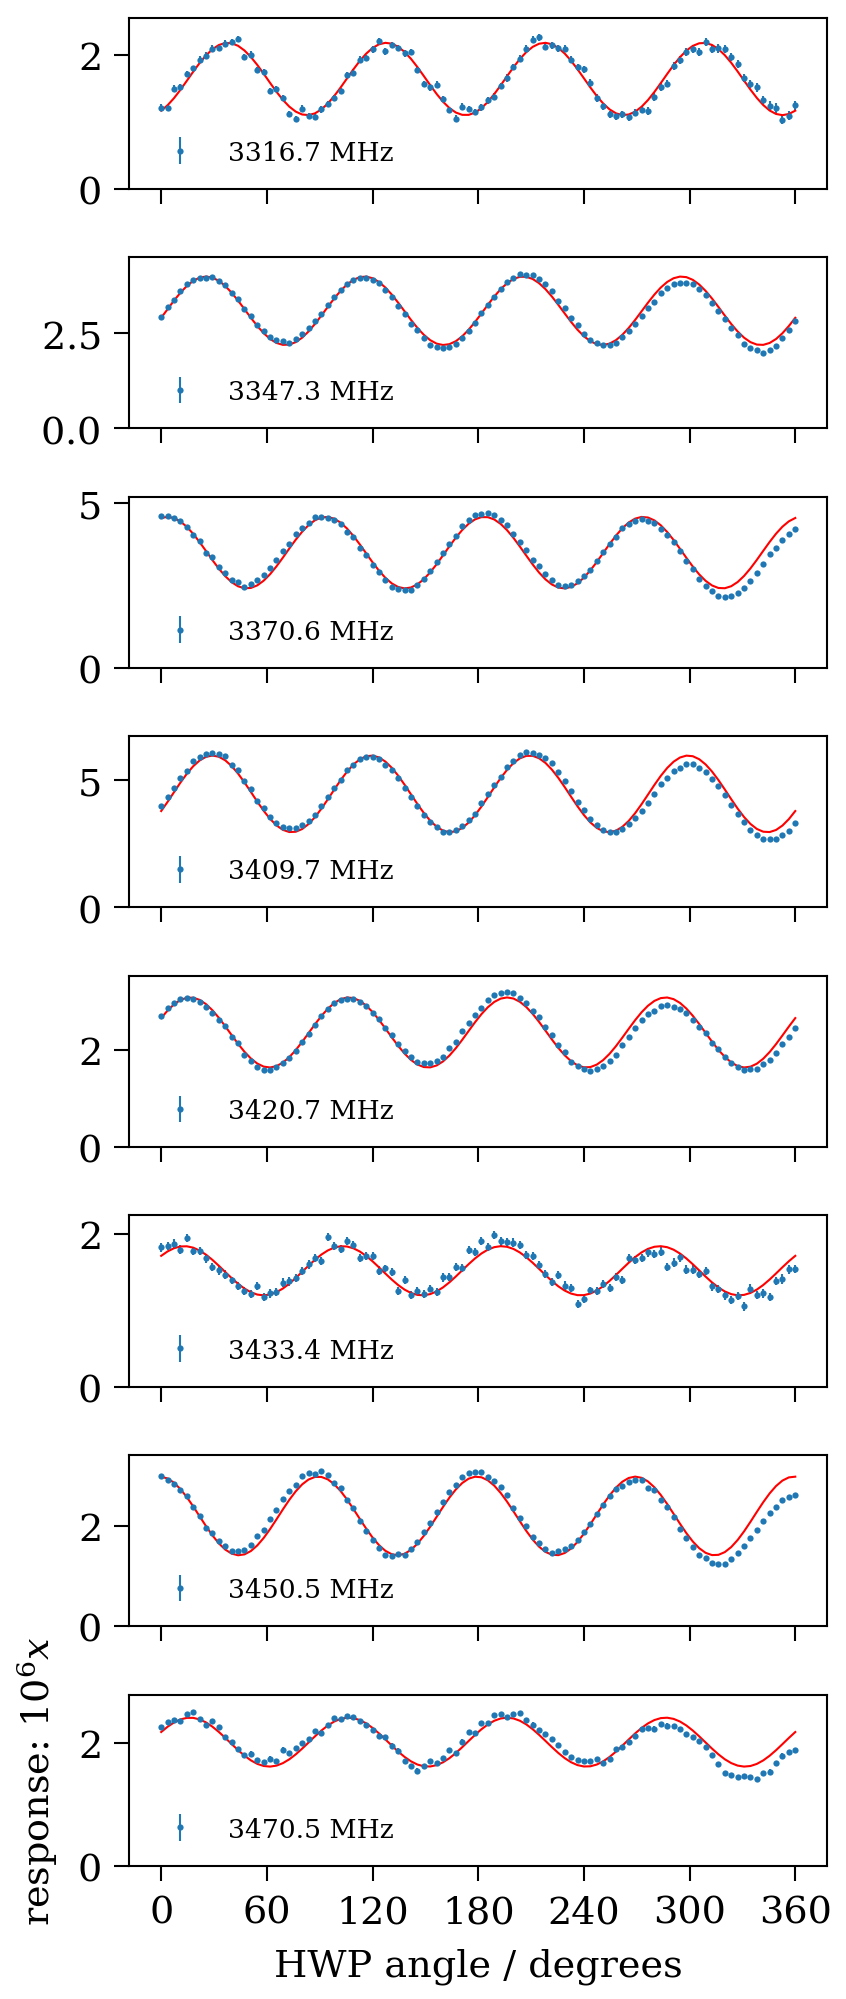

In [48]:
results = {}
fig, axes = plt.subplots(num_channels, figsize=(3, 1 * num_channels), gridspec_kw={'hspace': 0.4})
for number, ax in enumerate(axes):
    sssl = ssl[number]
    folded_mean = np.zeros(len(sssl.stream_list))
    folded_error = np.zeros(len(sssl.stream_list))
    for index, stream in enumerate(sssl.stream_list):
        x, q = sssl.x_and_q(index)
        x_fold = stream.fold(x)
        folded_mean[index], folded_error[index] = periodic.peak_to_peak(x_fold)
        folded_mean = np.abs(folded_mean)
    angles = np.linspace(0, 2 * np.pi, folded_mean.size)
    ax.errorbar(np.degrees(angles), 1e6 * folded_mean, yerr=1e6 * folded_error,
                marker='.', linestyle='none',
                label="{:.1f} MHz".format(1e-6 * sssl.single_sweep.resonator.f_0))
    ax.set_xticks(60 * np.arange(7))
    ax.set_xticklabels([])
    ax.set_ylim(0, 1e6 * (1.1 * folded_mean.max() + folded_error.max()))
    results[number] = modulation_model.fit(folded_mean, phi=angles, weights=folded_error ** -2,
                                           phi0=0, amplitude=folded_mean.ptp(), offset=folded_mean.mean())
#    ax.plot(np.degrees(angles), 1e6 * results[number].init_fit, '-', color='gray')
    ax.plot(np.degrees(angles), 1e6 * results[number].best_fit, '-', color='red')
    ax.legend(fontsize='xx-small')
axes[-1].set_ylabel('response: $10^{6} x$')
axes[-1].set_xlabel('HWP angle / degrees')
axes[-1].set_xticklabels([str(t) for t in 60 * np.arange(7)])

if save_hwp_response_fit_band_3317:
    fig.savefig(save_directory + 'hwp_response_fit_band_3317.pdf')

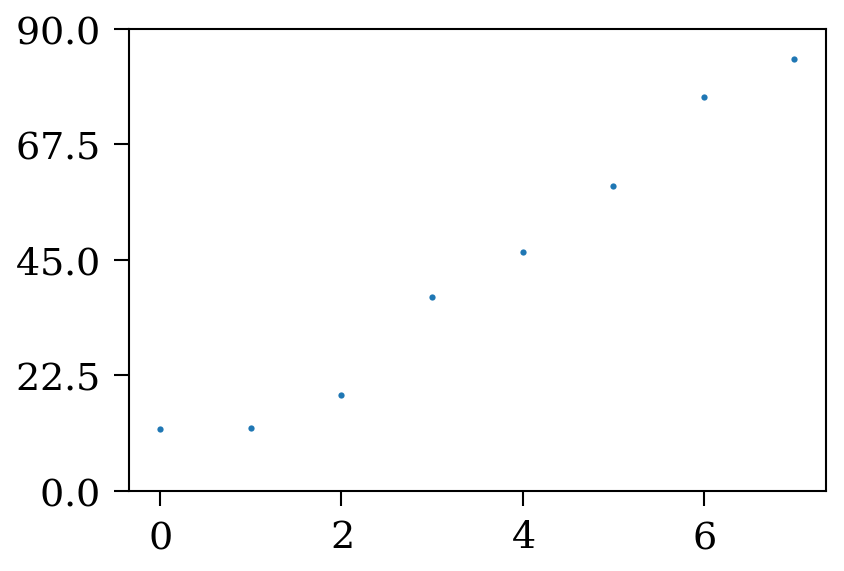

In [38]:
fig, ax = plt.subplots()
ax.plot(np.degrees(sorted([r.best_values['phi0'] % np.pi / 2 for r in results.values()])), '.')
ax.set_yticks([0, 22.5, 45, 67.5, 90]);

# Chosen one

In [55]:
chosen = ssl[3]
chosen.single_sweep.fit_resonator(model=lmfit_resonator.LinearLossResonatorWithCable)

In [56]:
chosen.stream_list[0].roach_state

StateDict({u'boffile': u'r2iq2xpfb14mcr18gb_2016_Jun_30_1104.bof', u'modulation_output': 2, u'modulation_rate': 7, u'fft_shift_register': 1048064, u'num_tone_samples': 16384, u'bank': 0, u'num_filterbank_channels': 16384, u'loopback': False, u'lo_frequency': 3305150564.916464, u'adc_sample_rate': 512000000.0, u'waveform_normalization': 0.00048828125, u'hardware_delay_samples': -16025.6, u'num_tones': 8, u'debug_register': 0, u'reference_sequence_number': 2299075486, u'dac_attenuation': 0.0, u'heterodyne': True})

In [57]:
print("resonance frequency is {:.1f} MHz".format(1e-6 * chosen.resonator.f_0))
print("internal loss is {:.3g} = 1 / {:.3g}".format(chosen.resonator.loss_i, 1 / chosen.resonator.loss_i))
print("coupling loss is {:.3g} = 1 / {:.3g}".format(chosen.resonator.loss_c, 1 / chosen.resonator.loss_c))

resonance frequency is 3409.7 MHz
internal loss is 8.39e-05 = 1 / 1.19e+04
coupling loss is 1.88e-05 = 1 / 5.31e+04


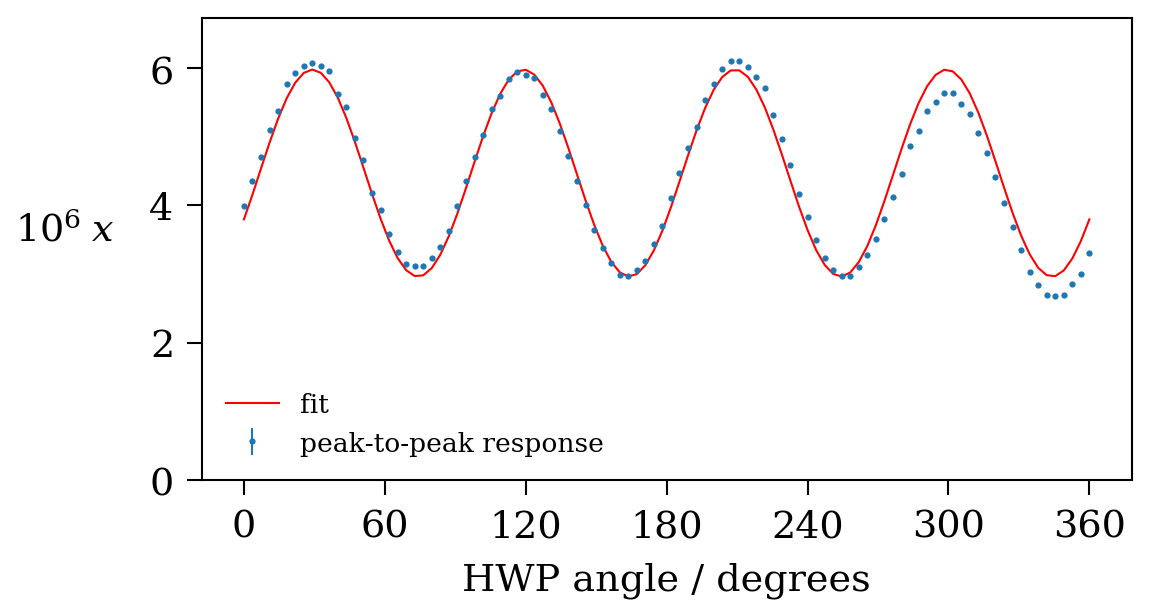

In [67]:
fig, ax = plt.subplots(figsize=(4, 2))
folded_mean = np.zeros(len(chosen.stream_list))
folded_error = np.zeros(len(chosen.stream_list))
for index, stream in enumerate(chosen.stream_list):
    x, q = chosen.x_and_q(index)
    x_fold = stream.fold(x)
    folded_mean[index], folded_error[index] = periodic.peak_to_peak(x_fold)
    folded_mean = np.abs(folded_mean)
    angles = np.linspace(0, 2 * np.pi, folded_mean.size)
ax.errorbar(np.degrees(angles), 1e6 * folded_mean, yerr=1e6 * folded_error,
            marker='.', linestyle='none', label='peak-to-peak response')
ax.set_xticks(60 * np.arange(7))
ax.set_ylim(0, 1e6 * (1.1 * folded_mean.max() + folded_error.max()))
chosen_result = modulation_model.fit(folded_mean, phi=angles, weights=folded_error ** -2,
                                     phi0=0, amplitude=folded_mean.ptp(), offset=folded_mean.mean())
ax.plot(np.degrees(angles), 1e6 * chosen_result.best_fit, '-', color='red', label='fit')
ax.legend(fontsize='xx-small')
ax.set_ylabel('$10^{6} \; x$', rotation='horizontal', labelpad=20)
ax.set_xlabel('HWP angle / degrees')
ax.set_xticklabels([str(t) for t in 60 * np.arange(7)])

if save_mkidarray02_chosen_one_fit_hwp:
    fig.savefig(thesis_directory + 'mkidarray02_chosen_one_fit_hwp.pdf')